In [30]:
from __future__ import annotations
import math
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


# Testing Value class

In [4]:
a = Value(2)
c = Value(3)
b = Value(4)

d = a * b
f = d + c
f

Value(data=11, grad=0.0)

In [5]:
f.grad = 1

In [6]:
f._backward()
d

Value(data=8, grad=1.0)

In [7]:
d._backward()
d

Value(data=8, grad=1.0)

In [8]:
c._backward()

In [9]:
d._backward()

In [10]:
a._backward()
b._backward()

In [11]:
a,b,c,d,f # checking populations of grads

(Value(data=2, grad=8.0),
 Value(data=4, grad=4.0),
 Value(data=3, grad=1.0),
 Value(data=8, grad=1.0),
 Value(data=11, grad=1))

In [12]:
d._prev

{Value(data=2, grad=8.0), Value(data=4, grad=4.0)}

In [13]:
c = Value(3)
x = c ** 4 
x

Value(data=81, grad=0.0)

In [14]:
x.grad = 1
x._backward()
c._backward()
c

Value(data=3, grad=108.0)

In [15]:
x._prev

{Value(data=3, grad=108.0)}

In [16]:
a = Value(2)
b = Value(4)
c = Value(3)

d = a * b      # 8
f = d + c      # 11

f.backward()   # builds topo, sets f.grad=1, backprops

print(a, b, c) # grads: df/da = 4, df/db = 2, df/dc = 1

Value(data=2, grad=4.0) Value(data=4, grad=2.0) Value(data=3, grad=1.0)


In [17]:
mat1 = Value([[1, 2, 3], [4, 5, 6]]) 
mat2 = Value([[1, 2], [3, 4], [5, 6]])

mat1@mat2

Value(data=[[22.0, 28.0], [49.0, 64.0]], grad=0.0)

# making sure scalar autograd works

In [18]:
# analysing on f(x) = (a*b + c).tanh()

a = Value(2.0)
b = Value(3.0)
c = Value(-7.0)

f = (a * b + c).tanh()

In [19]:
f.backward()

In [42]:
# creating dataset
# linear regression 

m = 3.2
b = 5.7

x = np.arange(1.0, 5.0, 0.05)

y = m * x + b

x.shape, y.shape , x[:5], y[:5]

((80,),
 (80,),
 array([1.  , 1.05, 1.1 , 1.15, 1.2 ]),
 array([8.9 , 9.06, 9.22, 9.38, 9.54]))

/var/folders/72/5nn2s8xs4q306c6lbyvj75vr0000gn/T/ipykernel_91335/2071282881.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


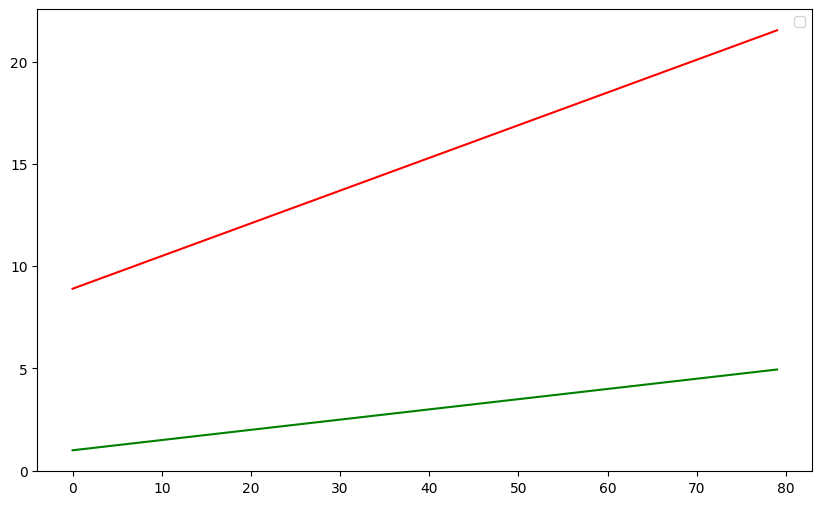

In [43]:
# visualizing the dataset

def plot(data: tuple):
    X, y = data[0], data[1]

    # plot
    plt.figure(figsize=(10, 6))
    plt.plot(X, c='g')
    plt.plot(y, c='r')
    plt.legend()
    plt.show()


plot((x, y))

In [22]:
# training a tiny model on this 

# weights and bias
W = Value(0.1)
b = Value(0.4)

